# Automatic Ticket Classification Case Study

## Problem Statement 

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:


* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. we can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Importing the necessary libraries

In [9]:
pip install swifter

Note: you may need to restart the kernel to use updated packages.


In [21]:
# # Libraries for data loading, Exploratory data visualization
# import swifter
# import json 
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# from plotly.offline import plot
# import plotly.graph_objects as go
# import plotly.express as px
# from wordcloud import WordCloud, STOPWORDS

# # Libraries for text preprocessing and analysis
# import re, nltk, spacy, string
# import en_core_web_sm
# nlp = en_core_web_sm.load(disable=['parser','ner'])
# from collections import Counter

# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from pprint import pprint



# import warnings
# warnings.filterwarnings('ignore')

In [22]:
# from google.colab import drive
# drive.mount('/content/drive')

In [31]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data
The data is in JSON format and we need to convert it to a dataframe.

In [15]:
# Opening JSON file 
with open('C:\\Users\\admin\\Downloads\\py\\Ticket Classification_NLP\\complaints-2021-05-14_08_16.json') as f:
    # returns JSON object as  
    # a dictionary 
    data = json.load(f)

df = pd.json_normalize(data)

In [16]:
# # Opening JSON file 
# f = 'C:\\Users\\admin\\Downloads\\py\\Ticket Classification_NLP\\complaints-2021-05-14_08_16.json'
  
# # returns JSON object as  
# # a dictionary 
# data = json.load(f)
# df=pd.json_normalize(data)

## Data preparation

#### Let's explore data using Data table display for Pandas dataframes

In [17]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [18]:
#Assign new column names
df.rename(columns={'_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint_what_happened', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)

In [19]:
# To display dataframe in form of interactive data table
from IPython.display import display
import pandas as pd

# Define function to enable data table formatter
def enable_dataframe_formatter():
    pd.set_option('display.notebook_repr_html', True)
    pd.set_option('display.max_columns', 25)
    pd.set_option('display.max_rows', 10000)
    pd.set_option('display.max_colwidth', None)

# Call function to enable data table formatter
enable_dataframe_formatter()


In [20]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [23]:
#Assign nan in place of blanks in the complaints column

df['complaint_what_happened'].replace('', np.nan, inplace=True)

In [24]:
#Remove all rows where complaints column is nan

df.dropna(subset=['complaint_what_happened'], inplace=True)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [26]:
import re
# Function to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    # Make the text lowercase
    text = text.lower()

    # Remove text in square brackets
    text = re.sub('\[.*?\]', '', text)

    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    # Remove text within curly braces
    text = re.sub('\{.*?\}', '', text)

    # Remove line breaks
    text = text.replace('\n', ' ')

    # Remove date
    text = re.sub('\d{4}-\d{2}-\d{2}', '', text)

    # Remove xxx characters 
    text = re.sub(r'xx+', '',text) 

    # Remove unnecessary white spaces
    text = re.sub(' +', ' ', text)


    return text

In [27]:
# test above function
text = 'This is some [sample] text with punctuation and numbers like 1, 2, 3 and dates like 2020-12-31 and xxxx-xxxx xx. It also contains text within {curly braces} and line breaks.\n'
clean_text = preprocess_text(text)
print(clean_text)

this is some text with punctuation and numbers like and dates like and it also contains text within curly braces and line breaks 


After all the cleaning operations, performed the following:

Lemmatize the texts Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [28]:
# Function to Lemmatize the texts
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
def lemmatization(text):
    tokens = word_tokenize(text)
    wordnet_lemmetizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmetizer.lemmatize(token) for token in tokens]
    lemmatized_str = " ".join(lemmatized)
    return lemmatized_str

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Apply data cleaning

In [29]:
# Apply data cleaning to the complaints_what_happened column

df['complaints'] = df['complaint_what_happened'].apply(preprocess_text)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Ba

In [32]:
df['lemmatized'] = df['complaints'].swifter.apply(lemmatization)
df.head()

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,complaints,lemmatized
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,N/A,"Credit reporting, credit repair services, or other personal consumer reports",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",Information belongs to someone else,Consent provided,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain

In [33]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

df_clean = df[['complaints','lemmatized']]

df_clean.head()

,complaints,lemmatized
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted and wa referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i wa told by the chase representative i spoke with that my application wa denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only get applied after the first account st

In [34]:
#Write your function to extract the POS tags 

def get_pos_tags(text):
    nn_words = []
    doc = nlp(text)
    for token in doc:
         # Filter only tokens which are Noun
        if(token.tag_ == 'NN'):
            nn_words.append(token.lemma_)
    # return string of tokens        
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#### Swifter library is used here for prallal operations on dataframe, resulting in faster processing

In [35]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean.swifter.apply(lambda x: get_pos_tags(x['lemmatized']), axis=1)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\3497728702.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(20)

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a reward card i put in my information for the offer and within le than a minute wa notified via the screen that a decision could not be made i immediately contacted and wa referred to chase bank i then immediately contacted chase bank w

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

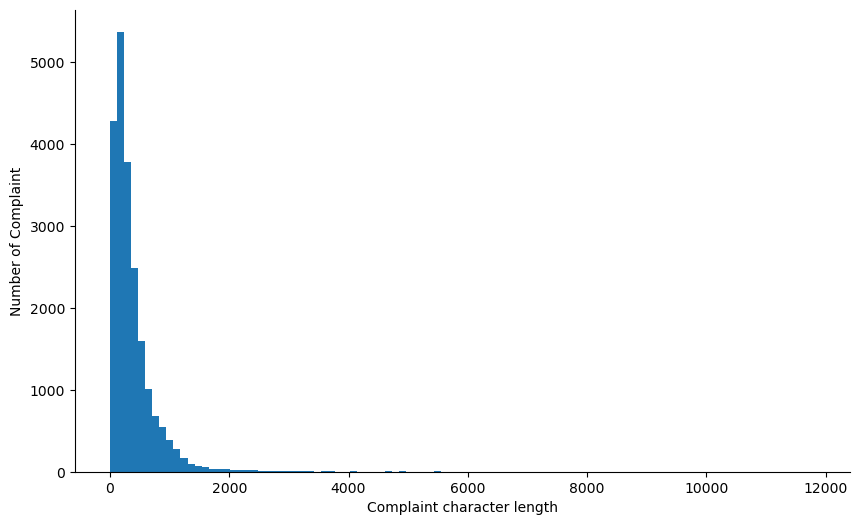

In [38]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 100)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

### Find the top 40 words by frequency among all the articles after processing the text.

In [41]:
conda install -c conda-forge wordcloud=1.6.0 

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
failed

Note: you may need to restart the kernel to use updated packages.



Examining wordcloud=1.6.0:  75%|#######5  | 3/4 [00:01<00:00,  1.27it/s]               
                                                                        

Examining conflict for python wordcloud:   0%|          | 0/4 [00:00<?, ?it/s]
                                                                              

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - wordcloud=1.6.0 -> python[version='>=2.7,<2.8.0a0|>=3.8,<3.9.0a0|>=3.7,<3.8.0a0|>=3.6,<3.7.0a0']

Your python: python=3.9

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained to. Note that conda will not
change your python version to a different minor version unless you explicitly specify
that.





In [45]:
pip install wordcloud

     -------------------------------------- 153.3/153.3 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


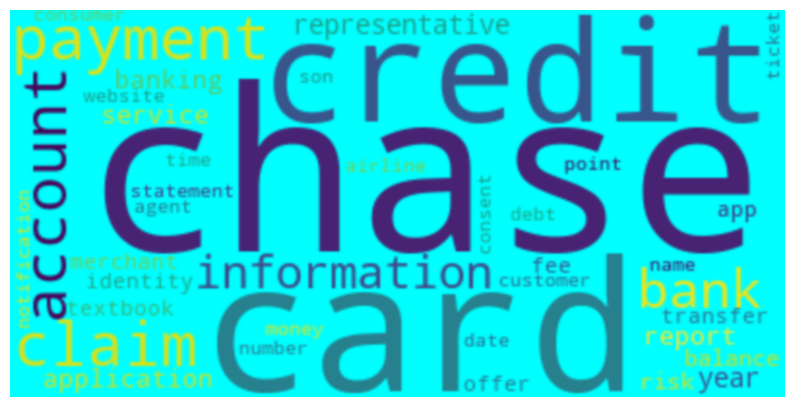

In [46]:
# Top 40 words frequency wise wordcloud
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS),background_color='cyan')
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()

In [47]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head(5)

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\1739077588.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to boo

### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [48]:
from collections import Counter
from nltk.util import ngrams
full_sent = ''
for i in df_clean["Complaint_clean"]:
  full_sent+=i+' '
allWords = nltk.tokenize.word_tokenize(full_sent)

In [49]:
unigrams = ngrams(allWords,1)
pd.DataFrame(Counter(unigrams).most_common(30))

,0,1
0,"(chase,)",53972
1,"(account,)",47375
2,"(credit,)",32641
3,"(card,)",30334
4,"(bank,)",21470
5,"(payment,)",21168
6,"(time,)",16036
7,"(day,)",12980
8,"(money,)",11956
9,"(charge,)",11952


In [50]:
unigrams = ngrams(allWords, 1)
freq = Counter(unigrams)
top_10 = freq.most_common(10)
for word, count in top_10:
    print(word[0], ":", count)

chase : 53972
account : 47375
credit : 32641
card : 30334
bank : 21470
payment : 21168
time : 16036
day : 12980
money : 11956
charge : 11952


In [51]:
bigrams = ngrams(allWords,2)
bigram_df=pd.DataFrame(Counter(bigrams).most_common(30))
bigram_df

,0,1
0,"(credit, card)",12866
1,"(credit, report)",3877
2,"(account, chase)",3374
3,"(customer, service)",3075
4,"(chase, credit)",3066
5,"(chase, account)",3055
6,"(account, account)",2775
7,"(bank, account)",2582
8,"(chase, bank)",2213
9,"(debit, card)",2034


In [52]:
bigrams = ngrams(allWords, 2)
freq = Counter(bigrams)
top_10 = freq.most_common(10)
for bigram, count in top_10:
    print(' '.join(bigram), ":", count)

credit card : 12866
credit report : 3877
account chase : 3374
customer service : 3075
chase credit : 3066
chase account : 3055
account account : 2775
bank account : 2582
chase bank : 2213
debit card : 2034


In [53]:
trigrams = ngrams(allWords,3)
pd.DataFrame(Counter(trigrams).most_common(30))

,0,1
0,"(chase, credit, card)",2023
1,"(credit, card, account)",1130
2,"(credit, card, company)",996
3,"(credit, card, chase)",802
4,"(credit, card, credit)",568
5,"(inquiry, credit, report)",558
6,"(account, credit, card)",514
7,"(card, credit, card)",469
8,"(credit, report, credit)",399
9,"(chase, checking, account)",391


In [54]:
trigrams = ngrams(allWords, 3)
freq = Counter(trigrams)
top_10 = freq.most_common(10)
for trigram, count in top_10:
    print(' '.join(trigram), ":", count)

chase credit card : 2023
credit card account : 1130
credit card company : 996
credit card chase : 802
credit card credit : 568
inquiry credit report : 558
account credit card : 514
card credit card : 469
credit report credit : 399
chase checking account : 391


In [55]:
df_clean.head(10)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to boo

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [56]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\619742717.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [57]:
#All masked texts has been removed
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while trying to boo

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [58]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [59]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])
dtm
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

,aa,aaaratings,aarp,ab,aba,aback,abandon,abandoned,abandonment,abate,abatement,abbreviation,...,yup,zelle,zero,zeroed,zeros,zilch,zip,zipcode,zombie,zone,zones,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


tfidf.get_feature_names()

In [74]:
tfidf.get_feature_names()

['aa',
 'aaaratings',
 'aarp',
 'ab',
 'aba',
 'aback',
 'abandon',
 'abandoned',
 'abandonment',
 'abate',
 'abatement',
 'abbreviation',
 'abd',
 'aberrant',
 'abet',
 'abetted',
 'abetting',
 'abhorrent',
 'abide',
 'abided',
 'abiding',
 'abilities',
 'ability',
 'able',
 'abnormal',
 'abnormally',
 'abou',
 'abovementioned',
 'abovenamed',
 'abovereferenced',
 'abrasive',
 'abreast',
 'abroad',
 'abrupt',
 'abruptly',
 'abs',
 'absconding',
 'absence',
 'absent',
 'absolute',
 'absolutely',
 'absolutly',
 'absolve',
 'absorb',
 'absorbed',
 'absurd',
 'absurdity',
 'absurdly',
 'abundance',
 'abundantly',
 'abuse',
 'abused',
 'abuser',
 'abuses',
 'abusing',
 'abusive',
 'abusively',
 'abysmal',
 'ac',
 'academic',
 'acc',
 'acccount',
 'acccounts',
 'accelerate',
 'accelerated',
 'accelerating',
 'acceleration',
 'accent',
 'accents',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepteddenied',
 'accepting',
 'accepts',
 'access',
 'accessed',
 'accesses',
 'accessib

In [60]:
len(tfidf.get_feature_names())

15710

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [61]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [62]:
#Load your nmf_model with the n_components i.e 5
N_TOPICS = 5
#keep the random_state =40
nmf = NMF(random_state=40, n_components=N_TOPICS)

In [63]:
W=nmf.fit(dtm) #Document Topic Matrix
H=nmf.components_# Topic Term Matrix

In [64]:
#Print the Top15 words for each of the topics
#get feature names as words
words = np.array(tfidf.get_feature_names())

#initialize df for Topic and corresponding 15 word
topic_words_df = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,called,fraud,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,removed,debt
Topic 3,loan,mortgage,chase,home,modification,property,payments,foreclosure,house,bank,years,jp,morgan,sale,rate
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,fee,month,fees,statement,account,charged,chase,monthly,make


In [65]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf.transform(dtm)
topic_results.argmax(axis=1)

array([2, 0, 1, ..., 0, 4, 4], dtype=int64)

In [66]:
#Assign the best topic to each of the complaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\2077841801.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [67]:
df_clean.head(10)

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,2
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while t

In [68]:
# Print the first 5 Complaint for each of the Topics
topic_df=df_clean[['complaints','Topic']].groupby('Topic').head(5)
topic_df.sort_values('Topic')

,complaints,Topic
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,0
21,on i made a payment to an online retailer using chase quick pay with on the chase website i realized that this was a scam website after no confirmation product or response to any inquiries regarding the order and contacted chase to get more information about the transaction to attempt getting a refund through the retailers bank i contacted chase via a secured message on explaining what happened and asked is there a way to reverse this transaction or do you have a contact at that can give me more information about the recipient that my message was reviewed and i received a response restating my original email and informing me that the transfer has been completed however as you mentioned that the website is a scam while we can handle most inquiries by email some require the expertise of another team in order to assist you better in regards to the refund we request you to call our consumer online technical support team i called the number listed in the email and explained my situation to then be transferred to the claims department i was directed to call and ask them about the transaction because chase did not have any information outside of what i provided when initiating the transfer i felt like this agent was trying to get me to end the call as quickly as possible and i had to interrupt her closing script to ask for a contact number at and didnt have an opportunity to get any information about what the right questions would be to ask or what words and phrases i should use to get the information i was looking for i called whos automated system initially directed me to call my bank because i used the banks app to initiate the transaction i called again to navigate their menus and talk to a customer service agent they told me that all of the information about the transaction would in chase s system because i used the banks app to perform the transaction she stayed on the line with me until i understood everything that i should ask and had a better understanding of the situation i ended the call and called chase again when i called chase the second time the agent tried to look up the information about the receiving bank but could not find any additional information she then asked me why i needed this information and i explained my situation again i was once again transferred to the claims department who told me that i needed to contact to get the information i was looking for after i told her that i had already contacted them she finally admitted that there was nothing that she could do due to the nature of the transaction and that these types of transactions are not secured she said that chase had no information about the recipient other than the email address that i inputted and that the recipients banking information was not kept in the system in both phone calls they asked if i initiated that transaction and used that to absolve themselves of all responsibility in regards to this matter during this whole process it felt like chase was not transparent about their policies regarding these types of transactions nor were they helpful in helping me get any information about the situation these transactions are advertised as a fast safe and easy way to send money but seem to be a dangerous way to do business i feel deceived by chase s advertising and further victimized by the way i was treated by the members on their customer service team,0
43,chase sent me an email today with the innocuous title important information regarding changes to your chase account they often use similar titles for ads and other communications in it they force me into binding arbitration despite that never being something i had agreed to and

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [69]:
# Create the dictionary of Topic names and Topics
Topics = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topics)

df_clean.head(5)

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\3226871163.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,Mortgage/Loan
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,Account Services
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,Others
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to a

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [70]:
# Create the dictionary again of Topic names and Topics

Topics = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topics)

df_clean.head(5)

C:\Users\admin\AppData\Local\Temp\ipykernel_7684\3664421676.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account thanks in advance for your help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,morning name stop bank service debt verification statement bank debt mail month debt right information consumer chase account advance help,2
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,i upgraded my card in and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent ha the recording of the agent who wa misled me,card agent anniversary date agent information order account anniversary date consent recording agent,card agent anniversary date agent information order account anniversary date consent recording agent,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card wa reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,card application identity consent service credit identity applicant,card application identity consent service credit identity applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while t

In [71]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['complaints','Topic']]

In [72]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it if you could help me put a stop to chase bank cardmember services in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information as a consumer chase account thanks in advance for your help,2
2,i upgraded my card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account changed my anniversary date from to without my consent has the recording of the agent who was misled me,0
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,1
11,on while trying to book a ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,1
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number claim number is with chase,3
...,...,...
78303,after being a chase card customer for well over a decade was offered multiple solicitations for acquiring new credit cards with chase all with bonus airline miles and hotel points was approved for all new cards with no annual fee for year after less than months with payment always paid as agreed chase closed all my cards one of my approved new cards was never activated but was sent to me chase has done harm to my credit has charged me an annual fee even though they cancelled my account failed to credit my points for both airlines and hotel failed to credit up to for enrollment and failed to credit airline charge as agreed upon,1
78309,on wednesday i called chas my visa credit card provider and asked how to make a claim under their purchase protection benefit on i purchased three high school textbooks for my year old daughter because she transferred to a new school all three books were damaged when a water bottle in her backpack broke the chase representative assured me the textbooks would be covered and instructed me to file a claim at i immediately went to the website and filed the claim including uploading all of the requested

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics

In [75]:
from sklearn.feature_extraction.text import TfidfTransformer


# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,confusion_matrix

In [77]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

## 1. Logistic Regression:

In [78]:
# Logistic Regression
lr = LogisticRegression(random_state=42,solver='sag')
lr.fit(X_train, y_train)
predicted = lr.predict(X_test)

In [79]:
print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1194
           1       0.96      0.95      0.95      1103
           2       0.97      0.95      0.96       923
           3       0.93      0.97      0.95      1400
           4       0.96      0.88      0.92       648

    accuracy                           0.95      5268
   macro avg       0.95      0.94      0.95      5268
weighted avg       0.95      0.95      0.95      5268



In [80]:
print(confusion_matrix(y_test, y_pred=predicted))

[[1143   17    1   33    0]
 [  27 1046    8   10   12]
 [  13    8  874   21    7]
 [  22    7    5 1361    5]
 [  16   12   16   31  573]]


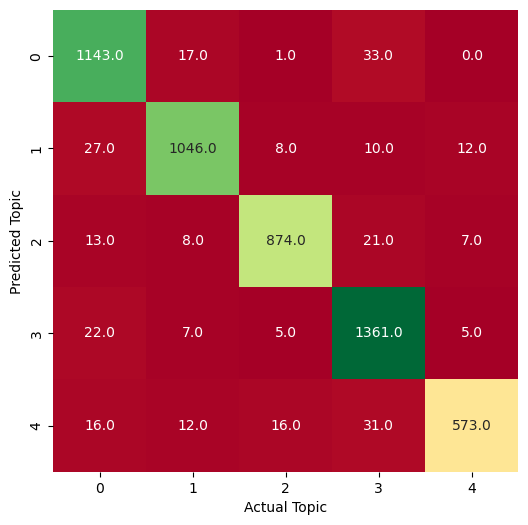

In [81]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual Topic")
plt.ylabel("Predicted Topic")
plt.show()

## 2. Decision Tree:

In [82]:
# Decision tree classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1194
           1       0.78      0.78      0.78      1103
           2       0.80      0.80      0.80       923
           3       0.78      0.81      0.80      1400
           4       0.72      0.69      0.70       648

    accuracy                           0.77      5268
   macro avg       0.76      0.76      0.76      5268
weighted avg       0.76      0.77      0.76      5268



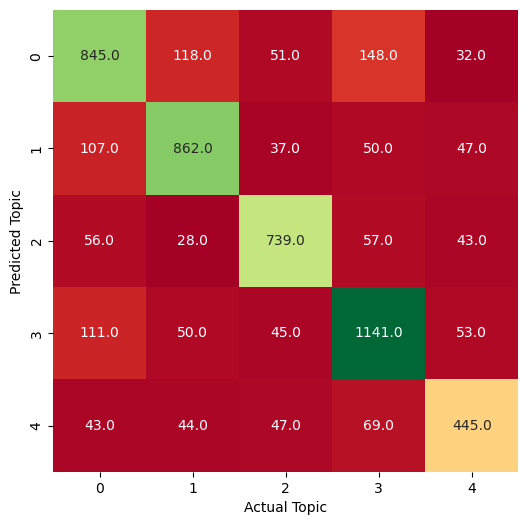

In [83]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual Topic")
plt.ylabel("Predicted Topic")
plt.show()

## 3. Random Forest Classifier:

In [84]:
rfc = RandomForestClassifier(max_depth=50)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1194
           1       0.82      0.84      0.83      1103
           2       0.89      0.89      0.89       923
           3       0.76      0.94      0.84      1400
           4       0.91      0.52      0.66       648

    accuracy                           0.82      5268
   macro avg       0.84      0.79      0.81      5268
weighted avg       0.83      0.82      0.82      5268



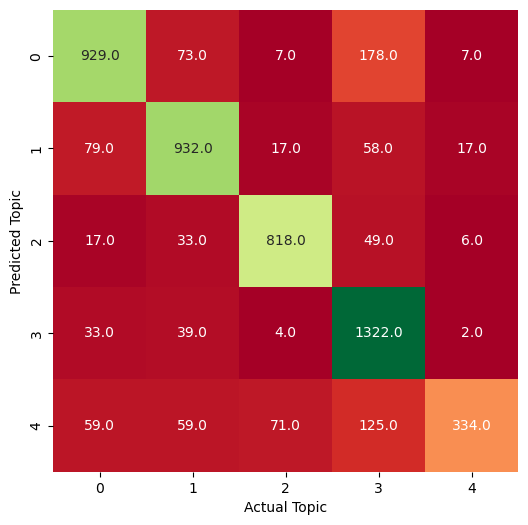

In [85]:
# Visualize Confusion Matrix with heatmap
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(confusion_matrix(y_test, predicted),
                 annot=True,
                 cbar=False,
                 cmap="RdYlGn", fmt = '0.1f')
plt.xlabel("Actual Topic")
plt.ylabel("Predicted Topic")
plt.show()

## 4. Gaussian Naive Bayes:

In [86]:
nb = GaussianNB()
nb.fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43      1194
           1       0.35      0.29      0.32      1103
           2       0.53      0.50      0.52       923
           3       0.45      0.29      0.36      1400
           4       0.19      0.50      0.28       648

    accuracy                           0.37      5268
   macro avg       0.41      0.39      0.38      5268
weighted avg       0.42      0.37      0.38      5268



#### Clearly Logistic Regression is performing better

## Infering the best model

In [87]:
# Some sample complaints to infer model

df_complaints = pd.DataFrame({'complaints': ["I am not happy with my credit card interest rate.", 
                                  "I have just received a statement of this account. It contains charges for purchases I have not made.",
                                  "I bought a new car. I paid the loan  but chase financial never release the title I contacted chase several time with no resolution each time they told me they will release it but nothing was done now i moved to another state and i can not get the registration in the other state because i do not have the title i will be obliged to rent a car since i can not use my car.",
                                  "summer month decline income employment month payment extension auto loan company chase past year request payment extension auto loan payment request month payment extension year situation supervisor avail discussion reason decline reason denial office director representative chase week representative office representative role matter representative conference call department request information request policy change explanation representative letter explanation letter reason denial wa policy change cfpb help denial payment extension request reason denial",
                                  "What is the procedure to know my CIBIL score?",
                                  "	to whom it may concern chase bank charged wrongly overdraft fees i have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but chase always changed the order and charged me overdraft fee anyway when you call they said their per their guidelines they dont refund more then overdrawft doesnt matter bank fault or not taken from people is money just because you can is not ok see attached documents when chase refund they always find the way to take back what they refunded in first place"]})
df_complaints

,complaints
0,I am not happy with my credit card interest rate.
1,I have just received a statement of this account. It contains charges for purchases I have not made.
2,I bought a new car. I paid the loan but chase financial never release the title I contacted chase several time with no resolution each time they told me they will release it but nothing was done now i moved to another state and i can not get the registration in the other state because i do not have the title i will be obliged to rent a car since i can not use my car.
3,summer month decline income employment month payment extension auto loan company chase past year request payment extension auto loan payment request month payment extension year situation supervisor avail discussion reason decline reason denial office director representative chase week representative office representative role matter representative conference call department request information request policy change explanation representative letter explanation letter reason denial wa policy change cfpb help denial payment extension request reason denial
4,What is the procedure to know my CIBIL score?
5,\tto whom it may concern chase bank charged wrongly overdraft fees i have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but chase always changed the order and charged me overdraft fee anyway when you call they said their per their guidelines they dont refund more then overdrawft doesnt matter bank fault or not taken from people is money just because you can is not ok see attached documents when chase refund they always find the way to take back what they refunded in first place


In [88]:
def predict_lr(text):
    Topics = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topics[predicted[0]]

In [89]:
df_complaints['Ticket_Category'] = df_complaints['complaints'].apply(lambda c: predict_lr([c]))
df_complaints

,complaints,Ticket_Category
0,I am not happy with my credit card interest rate.,Others
1,I have just received a statement of this account. It contains charges for purchases I have not made.,Account Services
2,I bought a new car. I paid the loan but chase financial never release the title I contacted chase several time with no resolution each time they told me they will release it but nothing was done now i moved to another state and i can not get the registration in the other state because i do not have the title i will be obliged to rent a car since i can not use my car.,Mortgage/Loan
3,summer month decline income employment month payment extension auto loan company chase past year request payment extension auto loan payment request month payment extension year situation supervisor avail discussion reason decline reason denial office director representative chase week representative office representative role matter representative conference call department request information request policy change explanation representative letter explanation letter reason denial wa policy change cfpb help denial payment extension request reason denial,Theft/Dispute Reporting
4,What is the procedure to know my CIBIL score?,Mortgage/Loan
5,\tto whom it may concern chase bank charged wrongly overdraft fees i have alert of low balance or unsuficent fee balance and always deposit immediatly to cover transactions if needed but chase always changed the order and charged me overdraft fee anyway when you call they said their per their guidelines they dont refund more then overdrawft doesnt matter bank fault or not taken from people is money just because you can is not ok see attached documents when chase refund they always find the way to take back what they refunded in first place,Theft/Dispute Reporting


# Conclusion:

* __As expected 5 topics were indetified namely:__
    1. Others
    2. Account Services 
    3. Mortgage/Loan
    4. Theft/Dispute Reporting 
    5. Credit card or prepaid card


* __Tried 4 models on the data with accuracies as follows:__

    1. Logistic Regression: 95%
    2. Decision Tree: 77%
    3. Random Forest: 82%
    4. Naive Bayes 37%

